## Starry versus numerical integration

Let's compute the RM effect amplitude for a planet transiting a star with a given inclination, obliquity, differential shear, and quadratic limb darkening. We'll do this numerically at first, then with `starry`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import starry
from ylm_rot import rv_field, get_ylm_coeffs
from tqdm import tqdm
%matplotlib inline

Here are all the star/planet parameters:

In [2]:
ro = 0.25
xo = -0.5
yo = -0.2
veq = 3250
obl = -30.0
inc = 75.0
alpha = 0.45
u1 = 0.4
u2 = 0.26

Let's plot the brightness-weighted radial velocity field:

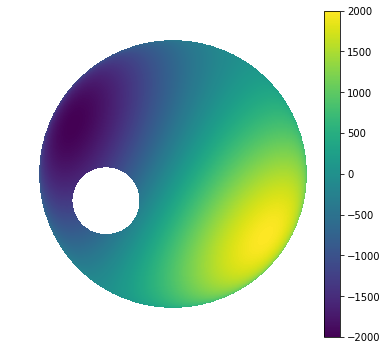

In [3]:
res = 1000
v = np.zeros((res, res)) * np.nan
I = np.zeros((res, res)) * np.nan
for j, x in enumerate(np.linspace(-1, 1, res)):
    for i, y in enumerate(np.linspace(-1, 1, res)):
        r2 = x ** 2 + y ** 2
        if r2 <= 1:
            if ((x - xo) ** 2 + (y - yo) ** 2 > ro ** 2):
                z = np.sqrt(1 - r2)
                v[i, j] = rv_field(x, y, z, veq, inc, obl, alpha)
                I[i, j] = 1 - (1 - z) * u1 - (1 - z) ** 2 * u2
fig = plt.figure(figsize=(6, 6))
plt.imshow(I * v, origin="lower")
plt.gca().axis('off');
plt.colorbar();

Now let's *numerically* compute the RV shift we would measure due to the RM effect:

In [6]:
res = 10000
intIv = 0
intI = 0
for j, x in tqdm(enumerate(np.linspace(-1, 1, res)), total=res):
    for i, y in enumerate(np.linspace(-1, 1, res)):
        r2 = x ** 2 + y ** 2
        if r2 <= 1:
            # We are inside the star
            if ((x - xo) ** 2 + (y - yo) ** 2 > ro ** 2):
                # We are outside the planet
                z = np.sqrt(1 - r2)
                I = 1 - (1 - z) * u1 - (1 - z) ** 2 * u2
                v = rv_field(x, y, z, veq, inc, obl, alpha)
                intIv += I * v
                intI += I
dV_num = intIv / intI
print(dV_num)

100%|██████████| 10000/10000 [10:11<00:00, 16.36it/s]

75.43064132948561


Finally, let's do it with `starry`. See the **note** in `DifferentialRotationWithSphericalHarmonics` for an explanation of what's going on here.

In [7]:
# Compute the integral of I * v + I over the visible disk
map = starry.Map(5)
map[:3, :] = get_ylm_coeffs(veq=veq, alpha=alpha, inc=inc, obl=obl)
map[0, 0] = 1
map[1] = u1
map[2] = u2
intIv_plus_I = map.flux(xo=xo, yo=yo, ro=ro)

# Compute the integral of I over the visible disk
map = starry.Map()
map[0, 0] = 1
map[1] = u1
map[2] = u2
intI = map.flux(xo=xo, yo=yo, ro=ro)

# The RM effect is the integral of Iv divided by the integral of I
dV_starry = (intIv_plus_I - intI) / intI
print(dV_starry)

75.43046108165868


It checks out!